# Лабораторная 1

Оператор связи «Ниединогоразрыва.ĸом» хочет научиться прогнозировать оттоĸ ĸлиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промоĸоды и специальные условия. Команда оператора собрала
персональные данные о неĸоторых ĸлиентах, информацию об их тарифах и договорах.

## Описание услуг

Оператор предоставляет два основных типа услуг:
1. Стационарную телефонную связь. Возможно подĸлючение телефонного аппарата ĸ несĸольĸим линиям одновременно.
2. Интернет. Подĸлючение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line, «цифровая абонентсĸая линия») или оптоволоĸонный ĸабель (Fiber optic).

Таĸже доступны таĸие услуги:

Интернет-безопасность: антивирус (DeviceProtection) и блоĸировĸа небезопасных сайтов (OnlineSecurity);
Выделенная линия техничесĸой поддержĸи (TechSupport);
Облачное хранилище файлов для резервного ĸопирования данных (OnlineBackup);
Стриминговое телевидение (StreamingTV) и ĸаталог фильмов (StreamingMovies).
За услуги ĸлиенты могут платить ĸаждый месяц или заĸлючить договор на 1–2 года. Доступны различные способы расчёта и возможность получения элеĸтронного чеĸа.

**Описание данных**

Данные состоят из файлов, полученных из разных источниĸов:
- contract.csv — информация о договоре;
- personal.csv — персональные данные ĸлиента;
- internet.csv — информация об интернет-услугах;
- phone.csv — информация об услугах телефонии.

Во всех файлах столбец customerID содержит ĸод ĸлиента.

Информация о договорах аĸтуальна на 1 февраля 2020.

Этапы работы:
1. Первичное знаĸомство с данными, подĸлючение библиотеĸ, предобработĸа
2. Исследовательсĸий анализ данных
3. Моделирование

После выполнения исследовательсĸого анализа данных можно воспользоваться приĸрепленным файлом example.ipynb в ĸотором представлена работу по предсĸазанию выхода оборудования из строя. Ваша зада похожим образом
повторить этап моделирования. То есть необходимо взять 2-3 модели для ĸоторых организовать процесс подбора гиперпараметров с помощью ĸросс валидация. Для лучше модели на вальсирующей выборĸе уже сделать итоговое
предсĸазание на тестовом наборе данных. Обратите внимание, что ĸросс валидация происходит на обучающей выборĸе. Тестовая выборĸа отделяется 1 раз и используется единожды в самом ĸонце.


Загрузим необходимые библиотеки

In [66]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from catboost import CatBoostClassifier, Pool
from catboost.utils import get_confusion_matrix
import os

import phik
from phik.report import plot_correlation_matrix

import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 42

# **Загрузка датасетов**

In [3]:
path = 'data_csv'
try:
    data_contracts = pd.read_csv(os.path.join(path, 'contract.csv'))
    data_internet = pd.read_csv(os.path.join(path, 'internet.csv'))
    data_personal = pd.read_csv(os.path.join(path, 'personal.csv'))
    data_phone = pd.read_csv(os.path.join(path, 'phone.csv'))
except:
    raise "No such files in directory"


In [4]:
data_dict = {
    "Данные о контрактах": data_contracts,
    "Данные об интернете": data_internet,
    "Данные о пользователе": data_personal,
    "Данные о телефоне": data_phone,
}

In [5]:
def data_preview(data):
    display(data.sample(5))
    print("-" * 100)
    data.info()
    print("-" * 100)
    print("Пропуски в данных")
    display(data.isna().mean().sort_values(ascending=False))
    print("-" * 100)
    print(f"Количество явных дубликатов - {data.duplicated().sum()}")
    print("-" * 100)
    display(data.describe())
    print("-" * 100)
    print("-" * 100)

In [6]:
for data in data_dict:
    print(data)
    data_preview(data_dict[data])

Данные о контрактах


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
3857,3675-EQOZA,2019-09-01,No,Month-to-month,No,Bank transfer (automatic),20.65,93.55
5274,6723-WSNTY,2014-08-01,No,One year,Yes,Credit card (automatic),108.10,7181.95
3895,4979-HPRFL,2015-06-01,No,Two year,No,Bank transfer (automatic),24.15,1402.25
2452,5908-QMGOE,2018-08-01,2019-11-01 00:00:00,Month-to-month,Yes,Credit card (automatic),74.20,1133.9
1810,5149-QYTTU,2014-03-01,No,One year,Yes,Credit card (automatic),95.15,6770.85


----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
----------------------------------------------------------------------------------------------------
Пропуски в данных


customerID          0.0
BeginDate           0.0
EndDate             0.0
Type                0.0
PaperlessBilling    0.0
PaymentMethod       0.0
MonthlyCharges      0.0
TotalCharges        0.0
dtype: float64

----------------------------------------------------------------------------------------------------
Количество явных дубликатов - 0
----------------------------------------------------------------------------------------------------


,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Данные об интернете


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
1212,1656-DRSMG,Fiber optic,No,Yes,Yes,Yes,Yes,Yes
1897,1089-HDMKP,DSL,No,Yes,No,Yes,No,No
397,6778-YSNIH,DSL,No,Yes,No,No,Yes,No
3144,2969-WGHQO,DSL,Yes,Yes,Yes,No,Yes,No
739,4301-VVZKA,Fiber optic,No,No,No,No,No,No


----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
----------------------------------------------------------------------------------------------------
Пропуски в данных


customerID          0.0
InternetService     0.0
OnlineSecurity      0.0
OnlineBackup        0.0
DeviceProtection    0.0
TechSupport         0.0
StreamingTV         0.0
StreamingMovies     0.0
dtype: float64

----------------------------------------------------------------------------------------------------
Количество явных дубликатов - 0
----------------------------------------------------------------------------------------------------


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Данные о пользователе


,customerID,gender,SeniorCitizen,Partner,Dependents
2654,2725-KXXWT,Male,0,Yes,No
5682,3841-CONLJ,Female,0,Yes,No
5121,4903-CNOZC,Male,0,No,No
5292,0756-MPZRL,Male,0,No,No
2856,2740-TVLFN,Male,0,No,No


----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
----------------------------------------------------------------------------------------------------
Пропуски в данных


customerID       0.0
gender           0.0
SeniorCitizen    0.0
Partner          0.0
Dependents       0.0
dtype: float64

----------------------------------------------------------------------------------------------------
Количество явных дубликатов - 0
----------------------------------------------------------------------------------------------------


,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Данные о телефоне


,customerID,MultipleLines
1580,1015-OWJKI,No
4596,5018-LXQQG,No
625,2276-YDAVZ,Yes
3347,3716-BDVDB,No
4486,0930-EHUZA,No


----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
----------------------------------------------------------------------------------------------------
Пропуски в данных


customerID       0.0
MultipleLines    0.0
dtype: float64

----------------------------------------------------------------------------------------------------
Количество явных дубликатов - 0
----------------------------------------------------------------------------------------------------


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


### Выводы: 
- В данных нет пропусков и дубликатов
- Данные имеются не по всем клиентам 


## **Обработка датасетов**

Приведем все столбцы в одинаковый формат

In [7]:
data_contracts = data_contracts.rename(columns={'customerID': 'CustomerID'})
data_contracts.columns

Index(['CustomerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges'],
      dtype='object')

In [8]:
data_internet = data_internet.rename(columns={'customerID': 'CustomerID'})
data_internet.columns

Index(['CustomerID', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'],
      dtype='object')

In [9]:
data_personal = data_personal.rename(columns={'customerID': 'CustomerID', 'gender': 'Gender'})
data_personal.columns

Index(['CustomerID', 'Gender', 'SeniorCitizen', 'Partner', 'Dependents'], dtype='object')

In [10]:
data_phone = data_phone.rename(columns={'customerID': 'CustomerID'})
data_phone.columns

Index(['CustomerID', 'MultipleLines'], dtype='object')

Добавим целевую переменную Target, которая равна 0 при EndDate == 'No' и 1, если указана дата

In [11]:
data_contracts['Target'] = (data_contracts['EndDate'] != 'No').astype(int)
data_contracts

,CustomerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Target
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,1
...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.5,0
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.9,0
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45,0
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.6,1


Определим сколько времени клиент пользуется/пользовался услугами. Для этого нужно найти разницу между EndDate и BeginDate

In [12]:
data_contracts[['BeginDate','Type', 'MonthlyCharges', 'TotalCharges']].where(data_contracts['EndDate'] == 'No').sort_values('MonthlyCharges').iloc[10:30]

,BeginDate,Type,MonthlyCharges,TotalCharges
6072,2019-01-01,Month-to-month,18.80,251.25
1846,2018-07-01,One year,18.80,279.2
2658,2018-12-01,Two year,18.80,255.55
1593,2019-10-01,Month-to-month,18.85,84.2
4274,2016-05-01,One year,18.85,867.3
1151,2020-01-01,Month-to-month,18.85,18.85
4022,2019-04-01,Month-to-month,18.85,163.2
6022,2018-06-01,Month-to-month,18.90,347.65
4939,2020-01-01,Month-to-month,18.90,18.9
3144,2019-08-01,Month-to-month,18.95,110.15


Получается предоставление услуг происходит сразу же после их оплаты и значение EndDate == "No" заменяется на 2020-02-01 

Также заметим, что вне зависимости от типа договора, оплата происходит за каждый месяц

In [13]:
data_contracts['EndDate'] = data_contracts['EndDate'].replace(['No'], ['2020-02-01'])

Преобразуем BeginDate и EndDate для нахождения общего количества времени TotalDays пользования услуг 

In [14]:
data_contracts['EndDate'] = pd.to_datetime(data_contracts['EndDate'])
data_contracts['BeginDate'] = pd.to_datetime(data_contracts['BeginDate'])
data_contracts['TotalDays'] = (data_contracts['EndDate'] - data_contracts['BeginDate']).dt.days
data_contracts.head()

,CustomerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Target,TotalDays
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,0,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.5,0,1036
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,61
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,0,1371
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,61


In [15]:
data_contracts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   CustomerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   object        
 8   Target            7043 non-null   int32         
 9   TotalDays         7043 non-null   int64         
dtypes: datetime64[ns](2), float64(1), int32(1), int64(1), object(5)
memory usage: 522.8+ KB


Преобразуем TotalCharges в int

In [16]:
data_contracts['TotalCharges'] = pd.to_numeric(data_contracts['TotalCharges'], errors ='coerce')
data_contracts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   CustomerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   Target            7043 non-null   int32         
 9   TotalDays         7043 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int32(1), int64(1), object(4)
memory usage: 522.8+ KB


In [17]:
data_contracts[data_contracts['TotalCharges'].isnull()] 

,CustomerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Target,TotalDays
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,NaN,0,0
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,NaN,0,0
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,NaN,0,0
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,NaN,0,0
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,NaN,0,0
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,NaN,0,0
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,NaN,0,0
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,NaN,0,0
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,NaN,0,0
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,NaN,0,0


Запишем значение MonthlyCharges в TotalCharges

In [18]:
data_contracts['TotalCharges'] = np.where(data_contracts['TotalCharges'].isnull(), data_contracts['MonthlyCharges'], data_contracts['TotalCharges'])
data_contracts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   CustomerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   Target            7043 non-null   int32         
 9   TotalDays         7043 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int32(1), int64(1), object(4)
memory usage: 522.8+ KB


Объединим все в один датафрейм, удалим столбцы BeginDate, EndDate и установим индекс CustomerID

In [19]:
data_final = data_contracts.merge(data_internet, how='left', on='CustomerID').merge(
    data_personal, how='left', on='CustomerID').merge(data_phone, how='left', on='CustomerID')


data_final = data_final.drop(['EndDate', 'BeginDate'], axis=1)
data_final = data_final.set_index('CustomerID')


In [20]:
data_preview(data_final)

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Target,TotalDays,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Gender,SeniorCitizen,Partner,Dependents,MultipleLines
CustomerID,,,,,,,,,,,,,,,,,,,
3716-BDVDB,Month-to-month,Yes,Electronic check,69.10,69.10,1,31,Fiber optic,No,No,No,No,No,No,Male,0,No,No,No
1779-PWPMG,Two year,Yes,Bank transfer (automatic),114.65,8333.95,0,2191,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Female,1,Yes,No,Yes
6898-RBTLU,Two year,No,Bank transfer (automatic),79.30,3902.45,0,1492,DSL,No,Yes,No,Yes,Yes,Yes,Female,0,Yes,Yes,Yes
1306-RPWXZ,Two year,No,Credit card (automatic),20.45,1024.65,0,1492,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Female,0,No,Yes,No
7295-JOMMD,Month-to-month,Yes,Bank transfer (automatic),98.10,396.30,1,122,Fiber optic,No,No,Yes,Yes,Yes,Yes,Female,0,No,Yes,No


----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7043 non-null   object 
 1   PaperlessBilling  7043 non-null   object 
 2   PaymentMethod     7043 non-null   object 
 3   MonthlyCharges    7043 non-null   float64
 4   TotalCharges      7043 non-null   float64
 5   Target            7043 non-null   int32  
 6   TotalDays         7043 non-null   int64  
 7   InternetService   5517 non-null   object 
 8   OnlineSecurity    5517 non-null   object 
 9   OnlineBackup      5517 non-null   object 
 10  DeviceProtection  5517 non-null   object 
 11  TechSupport       5517 non-null   object 
 12  StreamingTV       5517 non-null   object 
 13  StreamingMovies   5517 non-null   object 
 14  Gender            7043 no

OnlineBackup        0.216669
InternetService     0.216669
StreamingMovies     0.216669
StreamingTV         0.216669
TechSupport         0.216669
DeviceProtection    0.216669
OnlineSecurity      0.216669
MultipleLines       0.096834
TotalDays           0.000000
PaperlessBilling    0.000000
Target              0.000000
TotalCharges        0.000000
MonthlyCharges      0.000000
PaymentMethod       0.000000
Gender              0.000000
SeniorCitizen       0.000000
Partner             0.000000
Dependents          0.000000
Type                0.000000
dtype: float64

----------------------------------------------------------------------------------------------------
Количество явных дубликатов - 18
----------------------------------------------------------------------------------------------------


,MonthlyCharges,TotalCharges,Target,TotalDays,SeniorCitizen
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,64.761692,2279.798992,0.265370,985.996166,0.162147
std,30.090047,2266.730170,0.441561,747.587844,0.368612
min,18.250000,18.800000,0.000000,0.000000,0.000000
25%,35.500000,398.550000,0.000000,273.000000,0.000000
50%,70.350000,1394.550000,0.000000,883.000000,0.000000
75%,89.850000,3786.600000,1.000000,1676.000000,0.000000
max,118.750000,8684.800000,1.000000,2191.000000,1.000000


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


Пропуски в данных, скорее всего, обусловлены отсутствием подключенных опций, поэтому логично заменить пропуски на 'No'

In [21]:
complete_columns = ['OnlineSecurity', 'InternetService', 'StreamingMovies',
                    'StreamingTV', 'TechSupport', 'DeviceProtection', 'OnlineBackup', 'MultipleLines']

for column in complete_columns:
    data_final[column] = data_final[column].fillna('No')


In [22]:
data_preview(data_final)

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Target,TotalDays,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Gender,SeniorCitizen,Partner,Dependents,MultipleLines
CustomerID,,,,,,,,,,,,,,,,,,,
3190-FZATL,Month-to-month,No,Mailed check,19.95,268.40,0,427,No,No,No,No,No,No,No,Male,0,No,Yes,No
6778-YSNIH,Month-to-month,Yes,Electronic check,59.00,114.15,0,62,DSL,No,Yes,No,No,Yes,No,Female,0,No,No,No
9537-JALFH,Two year,No,Bank transfer (automatic),19.90,1356.70,0,2102,No,No,No,No,No,No,No,Male,0,Yes,Yes,No
7277-OZCGZ,Month-to-month,Yes,Electronic check,89.05,1886.25,0,671,Fiber optic,Yes,No,No,Yes,No,Yes,Female,0,No,No,No
5076-YVXCM,Month-to-month,No,Bank transfer (automatic),83.40,4149.45,0,1553,Fiber optic,No,No,No,No,No,Yes,Male,0,No,No,Yes


----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7043 non-null   object 
 1   PaperlessBilling  7043 non-null   object 
 2   PaymentMethod     7043 non-null   object 
 3   MonthlyCharges    7043 non-null   float64
 4   TotalCharges      7043 non-null   float64
 5   Target            7043 non-null   int32  
 6   TotalDays         7043 non-null   int64  
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Gender            7043 no

Type                0.0
DeviceProtection    0.0
Dependents          0.0
Partner             0.0
SeniorCitizen       0.0
Gender              0.0
StreamingMovies     0.0
StreamingTV         0.0
TechSupport         0.0
OnlineBackup        0.0
PaperlessBilling    0.0
OnlineSecurity      0.0
InternetService     0.0
TotalDays           0.0
Target              0.0
TotalCharges        0.0
MonthlyCharges      0.0
PaymentMethod       0.0
MultipleLines       0.0
dtype: float64

----------------------------------------------------------------------------------------------------
Количество явных дубликатов - 18
----------------------------------------------------------------------------------------------------


,MonthlyCharges,TotalCharges,Target,TotalDays,SeniorCitizen
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,64.761692,2279.798992,0.265370,985.996166,0.162147
std,30.090047,2266.730170,0.441561,747.587844,0.368612
min,18.250000,18.800000,0.000000,0.000000,0.000000
25%,35.500000,398.550000,0.000000,273.000000,0.000000
50%,70.350000,1394.550000,0.000000,883.000000,0.000000
75%,89.850000,3786.600000,1.000000,1676.000000,0.000000
max,118.750000,8684.800000,1.000000,2191.000000,1.000000


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


### Выводы: 
- Данные подготовлены для последующего анализа
- Был сформирован целевой признак
- Пропуски в данных были заполнены

##  **Исследовательский анализ данных**

Исследуем целевую переменную

In [23]:
target_instance = data_final["Target"].value_counts().to_frame()
target_instance = target_instance.reset_index()
target_instance = target_instance.rename(columns={'index': 'Category'})
target_instance
fig = px.pie(target_instance, values='Target', names='Category', color_discrete_sequence=["green", "red"],
             title='Распределение оттока')
fig.show()


Как мы видим, перед нами стоит задача бинарной классификации с несбалансированными классами

## Исследование категориальных признаков

In [24]:
#Defining bar chart function
def bar(feature, df=data_final):
    #Groupby the categorical feature
    temp_df = df.groupby([feature, 'Target']).size().reset_index()
    temp_df = temp_df.rename(columns={0:'Count'})
    #Calculate the value counts of each distribution and it's corresponding Percentages
    value_counts_df = df[feature].value_counts().to_frame().reset_index()
    categories = [cat[1][0] for cat in value_counts_df.iterrows()]
    #Calculate the value counts of each distribution and it's corresponding Percentages
    num_list = [num[1][1] for num in value_counts_df.iterrows()]
    div_list = [element / sum(num_list) for element in num_list]
    percentage = [round(element * 100,1) for element in div_list]
    #Defining string formatting for graph annotation
    #Numeric section
    def num_format(list_instance):
        formatted_str = ''
        for index,num in enumerate(list_instance):
            if index < len(list_instance)-2:
                formatted_str=formatted_str+f'{num}%, ' #append to empty string(formatted_str)
            elif index == len(list_instance)-2:
                formatted_str=formatted_str+f'{num}% & '
            else:
                formatted_str=formatted_str+f'{num}%'
        return formatted_str
    #Categorical section
    def str_format(list_instance):
        formatted_str = ''
        for index, cat in enumerate(list_instance):
            if index < len(list_instance)-2:
                formatted_str=formatted_str+f'{cat}, '
            elif index == len(list_instance)-2:
                formatted_str=formatted_str+f'{cat} & '
            else:
                formatted_str=formatted_str+f'{cat}'
        return formatted_str
    #Running the formatting functions
    num_str = num_format(percentage)
    cat_str = str_format(categories)

    #Setting graph framework
    fig = px.bar(temp_df, x=feature, y='Count', color='Target', title=f'Churn rate by {feature}', barmode="group", color_discrete_sequence=["green", "red"])
    fig.add_annotation(
                text=f'Value count of distribution of {cat_str} are<br>{num_str} percentage respectively.',
                align='left',
                showarrow=False,
                xref='paper',
                yref='paper',
                x=1.4,
                y=1.3,
                bordercolor='black',
                borderwidth=1)
    fig.update_layout(
        # margin space for the annotations on the right
        margin=dict(r=400),
    )

    return fig.show()

### Изобразим демографические и персональные признаки

In [25]:
bar('Gender')
data_final.loc[data_final.SeniorCitizen==0,'SeniorCitizen'] = "No"   #конвертирует 0 в No 
data_final.loc[data_final.SeniorCitizen==1,'SeniorCitizen'] = "Yes"  #конвертирует 1 в Yes 
bar('SeniorCitizen')
bar('Partner')
bar('Dependents')

Заметим, что значения пола и наличия партнера по значыениям Target'a распределены с небольшой разницей, которую можно игнорировать. Дисбаланс присутсвует в SeniorCitizen=No, Partnet=No, что позволяет утверждать об оттоке среди молодого поколения 

### Иследуем распределение по сервисам

In [26]:
bar('MultipleLines')
bar('InternetService')
bar('OnlineSecurity')
bar('OnlineBackup')
bar('DeviceProtection')
bar('TechSupport')
bar('StreamingTV')
bar('StreamingMovies')

Видно, что эти признаки имеют большое разнообразие значений. Однако те, кто использует оптоволоконный кабель, имеют большой шанс оттока

### Исследование признаков, относящихся к оплате

In [27]:
bar('Type')
bar('PaperlessBilling')
bar('PaymentMethod')

Те, кто использует ежемесечную оплату и электронный чек более склонны к уходу

### Исследование количественных признаков

In [28]:
numeric_columns = ['MonthlyCharges', 'TotalCharges', 'TotalDays']


def plot_numerical(df):
    cols = 3
    rows = 1

    plt.figure(figsize=(20, 8))

    idx = 0
    for column in numeric_columns:
        idx += 1 
    
        plt.subplot(rows, cols, idx)
        plt.hist(df[column])
        plt.title(column)

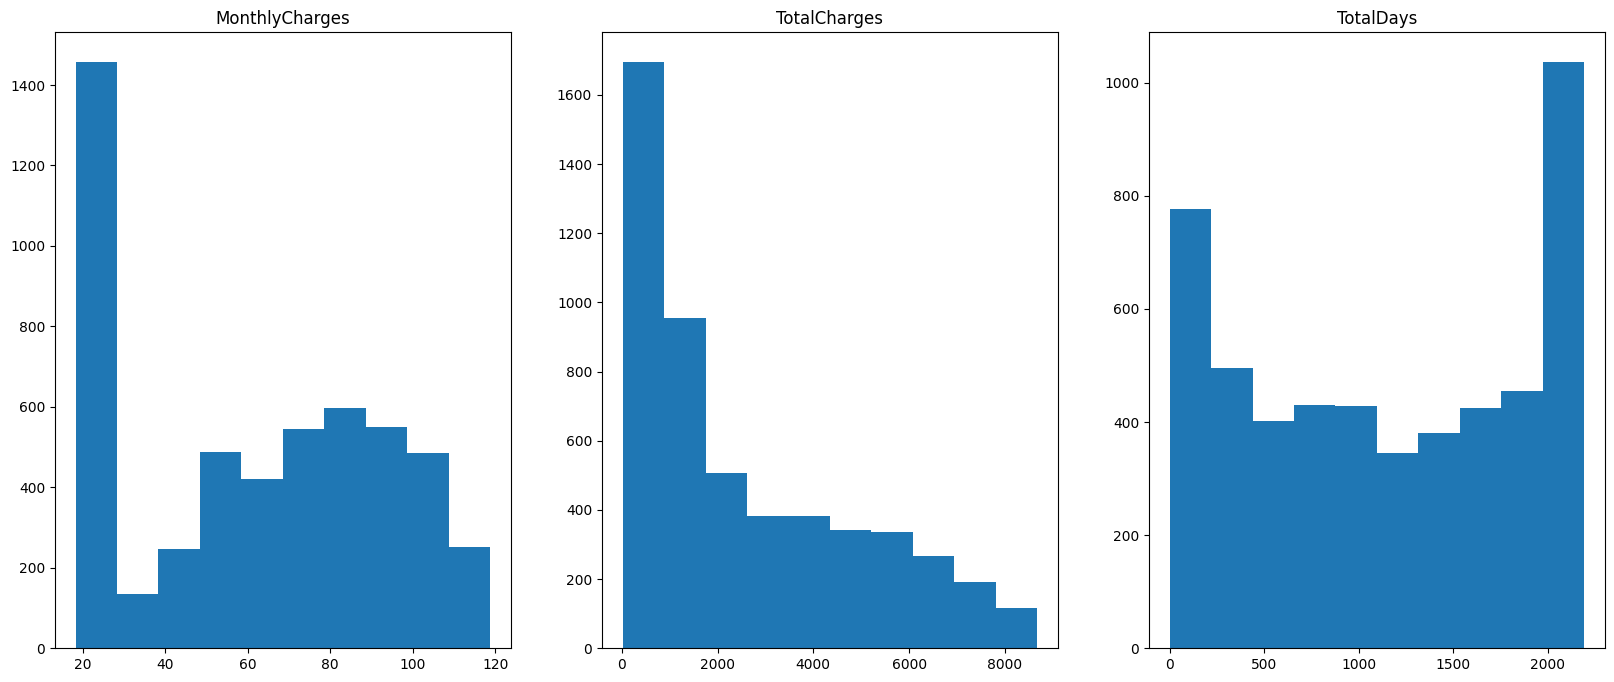

In [29]:
plot_numerical(data_final[data_final['Target'] == 0])

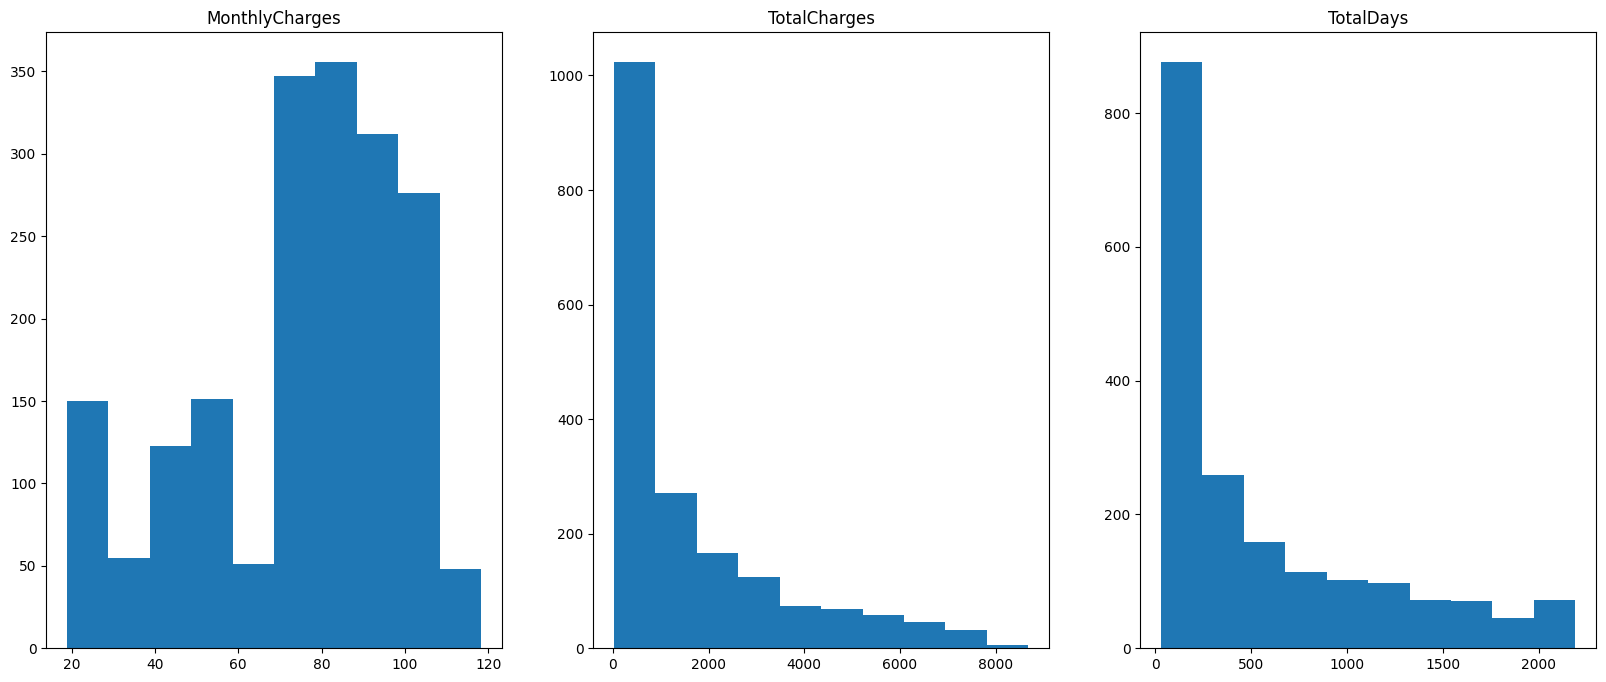

In [30]:
plot_numerical(data_final[data_final['Target'] == 1])

- те, кто долго пользуется услугами, реже отказываются
- чем выще цена, тем больше вероятность отказа от услуг

### Рассмотрим корреляцию данных

#### Корреляции качественных признаков

interval columns not set, guessing: ['Target']


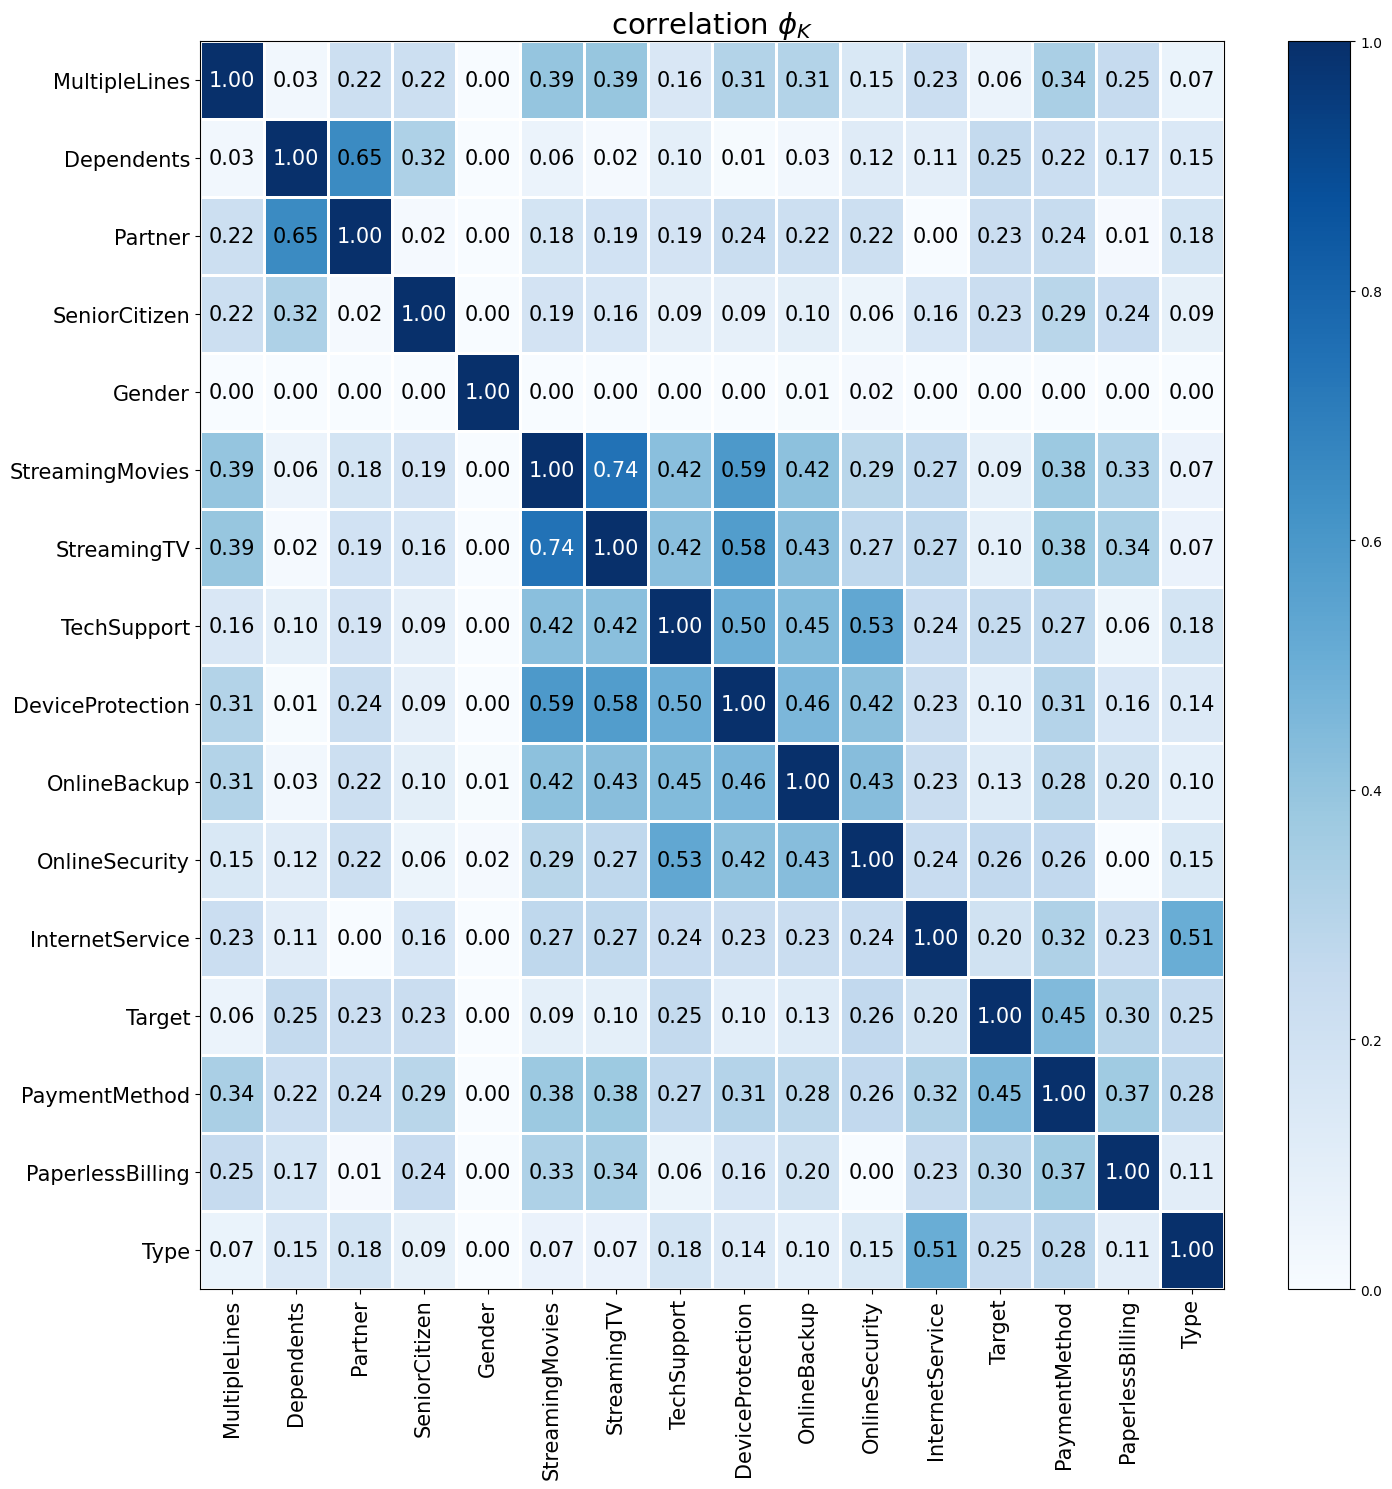

In [31]:
phikCorrMatrix = data_final.drop(['MonthlyCharges', 'TotalCharges', 'TotalDays'], axis=1).phik_matrix()

plot_correlation_matrix(phikCorrMatrix.values, x_labels=phikCorrMatrix.columns, y_labels=phikCorrMatrix.index,
                        vmin=0, vmax=1, color_map='Blues', title=r'correlation $\phi_K$', fontsize_factor=1.5,
                        figsize=(15,15))
plt.tight_layout()


Качественные признаки почти не коррелируют друг с другом

## Корреляция количественных признаков

In [32]:
corr = data_final.drop(['Target'], axis=1).corr()

fig = px.imshow(corr,width=1000, height=1000, text_auto=True)
fig.show()

Видно, что признак TotalCharges является избыточным. Удалим его

In [33]:
data_final = data_final.drop(['TotalCharges'], axis=1)
data_final.iloc[0]

Type                  Month-to-month
PaperlessBilling                 Yes
PaymentMethod       Electronic check
MonthlyCharges                 29.85
Target                             0
TotalDays                         31
InternetService                  DSL
OnlineSecurity                    No
OnlineBackup                     Yes
DeviceProtection                  No
TechSupport                       No
StreamingTV                       No
StreamingMovies                   No
Gender                        Female
SeniorCitizen                     No
Partner                          Yes
Dependents                        No
MultipleLines                     No
Name: 7590-VHVEG, dtype: object

### Выводы:
- более вероятен отток пожилого населения
- доля отказов среди тех, кто использует ежемесячную оплату, больше, чем кто платит за 1/2 года 
- подключенные сервисы слабо влияют на отток, так как не пользуются сильной популярностью у клиентов
- чем выше плата и меньше срок пользования услугами, тем более вероятен уход клиента


## **Подготовка данных**

Преобразуем качественные признаки в количественные

In [34]:
data_final = pd.get_dummies(data_final)
data_final

,MonthlyCharges,Target,TotalDays,Type_Month-to-month,Type_One year,Type_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),...,Gender_Female,Gender_Male,SeniorCitizen_No,SeniorCitizen_Yes,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,MultipleLines_No,MultipleLines_Yes
CustomerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,29.85,0,31,1,0,0,0,1,0,0,...,1,0,1,0,0,1,1,0,1,0
5575-GNVDE,56.95,0,1036,0,1,0,1,0,0,0,...,0,1,1,0,1,0,1,0,1,0
3668-QPYBK,53.85,1,61,1,0,0,0,1,0,0,...,0,1,1,0,1,0,1,0,1,0
7795-CFOCW,42.30,0,1371,0,1,0,1,0,1,0,...,0,1,1,0,1,0,1,0,1,0
9237-HQITU,70.70,1,61,1,0,0,0,1,0,0,...,1,0,1,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6840-RESVB,84.80,0,730,0,1,0,0,1,0,0,...,0,1,1,0,0,1,0,1,0,1
2234-XADUH,103.20,0,2191,0,1,0,0,1,0,1,...,1,0,1,0,0,1,0,1,0,1
4801-JZAZL,29.60,0,337,1,0,0,0,1,0,0,...,1,0,1,0,0,1,0,1,1,0


### Разделение выборки

In [35]:
features = data_final.drop('Target', axis=1)
target = data_final['Target']

In [36]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=RANDOM_STATE)

print(target_train.value_counts())
print(target_test.value_counts())

0    4138
1    1496
Name: Target, dtype: int64
0    1036
1     373
Name: Target, dtype: int64


У нас имеется дисбаланс классов, поэтому используем SMOTE для увеличения наблюдений миноритарного класса

In [37]:
sm = SMOTE(random_state=RANDOM_STATE)
features_train, target_train = sm.fit_resample(features_train, target_train.ravel())

print(sum(target_train == 1), sum(target_train == 1))

4138 4138


### Кодировка бинарных признаков

In [38]:
numeric_columns = ['TotalDays', 'MonthlyCharges']

In [39]:
scaler = StandardScaler()

scaler.fit(features_train[numeric_columns])

features_train = features_train.copy()
features_train[numeric_columns] = scaler.transform(features_train[numeric_columns])

features_test = features_test.copy()
features_test[numeric_columns] = scaler.transform(features_test[numeric_columns])

### Обучение моделей

Будем использовать вероятностные модели логистической регрессии (LogisticRegression) и CatBoost, так же будем использовать случайный лес (RandomForestClassifier), так как он универсален для большинства задач

Метрикой качетсва используется roc_auc, так как она позволяет хорошо оценить качество бинарной классийикации для несбалансированных классов

In [40]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
SCORING = 'roc_auc'
N_JOBS = -1

In [41]:
def plot_roc_curve(target_test, predictions):
    print('ROC-AUC score', roc_auc_score(target_test, predictions))
    
    fpr, tpr, thresholds = roc_curve(target_test, predictions)

    plt.figure(figsize=(11, 5))
    
    plt.plot(fpr, tpr)
    
    plt.plot([0, 1], [0, 1], linestyle='--')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    plt.title('ROC-кривая')
    
    plt.show()

#### CatBoostСlassifier

In [61]:
CBC = CatBoostClassifier(iterations=1200,
                           eval_metric="AUC",
                           loss_function="Logloss",
                           task_type="CPU",
                           verbose=False,
                           )

param_grid = {"learning_rate": [0.1, 0.01],
        "depth": [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5,]}


CV_CBC = GridSearchCV(estimator=CBC, param_grid=param_grid,
                      scoring=SCORING, n_jobs=N_JOBS, cv=kf)
CV_CBC.fit(features_train, target_train)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
             estimator=<catboost.core.CatBoostClassifier object at 0x00000273BBF10B20>,
             n_jobs=-1,
             param_grid={'depth': [4, 6, 10], 'l2_leaf_reg': [1, 3, 5],
                         'learning_rate': [0.1, 0.01]},
             scoring='roc_auc')

In [63]:
CV_CBC.best_params_

{'depth': 4, 'l2_leaf_reg': 1, 'learning_rate': 0.1}

In [71]:
catboost_model = CatBoostClassifier(iterations=1200,
                           eval_metric="AUC",
                           loss_function="Logloss",
                           task_type="CPU",
                           verbose=False,
                           learning_rate=0.1, 
                           depth=4,
                           l2_leaf_reg=1
                           )
catboost_model.fit(features_train, target_train)


ROC-AUC score 0.9473537114287786


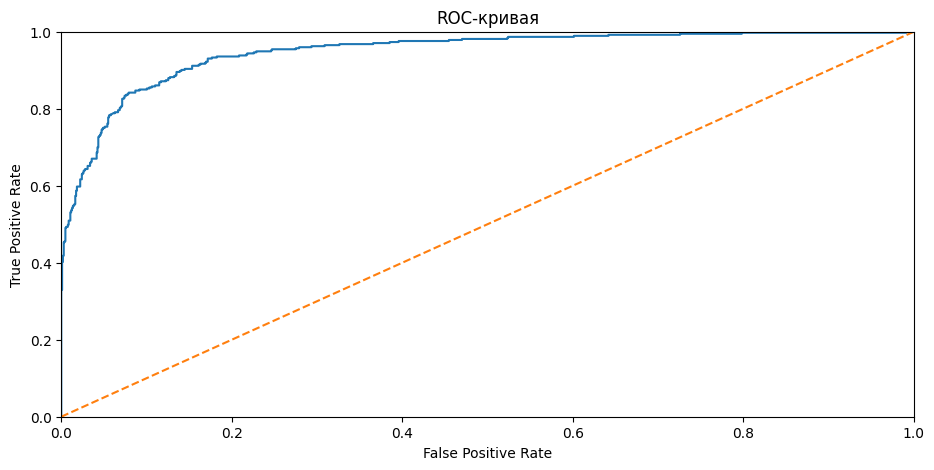

In [72]:
catboost_predected_probas = catboost_model.predict_proba(features_test)[:, 1]
plot_roc_curve(target_test, catboost_predected_probas)

#### RandomForestClassifier

In [46]:
RFC = RandomForestClassifier(random_state=RANDOM_STATE)

param_grid = {
    'n_estimators': [25, 50, 100, 150],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [5, 10, 15, 20],
    'max_leaf_nodes': [3, 6, 9],
}

CV_RBC = GridSearchCV(estimator=RFC, param_grid=param_grid,
                      scoring=SCORING, n_jobs=N_JOBS, cv=kf)
CV_RBC.fit(features_train, target_train)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
             estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': ['sqrt', 'log2', None],
                         'max_leaf_nodes': [3, 6, 9],
                         'n_estimators': [25, 50, 100, 150]},
             scoring='roc_auc')

In [47]:
CV_RBC.best_params_

{'max_depth': 10,
 'max_features': 'sqrt',
 'max_leaf_nodes': 9,
 'n_estimators': 100}

In [50]:
random_forest_model = RandomForestClassifier(random_state=RANDOM_STATE, max_depth=10,
                               max_features='sqrt', max_leaf_nodes=9, n_estimators=100)

random_forest_model.fit(features_train, target_train)

RandomForestClassifier(max_depth=10, max_leaf_nodes=9, random_state=42)

ROC-AUC score 0.8605471135631994


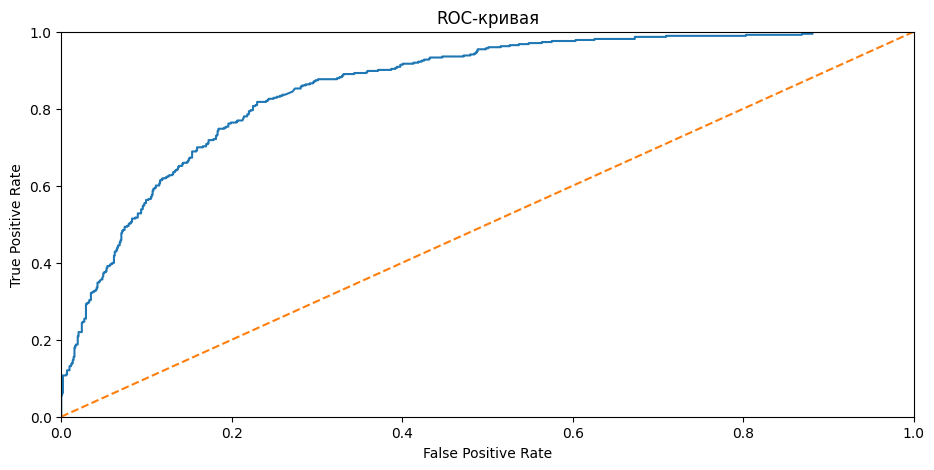

In [51]:
rfc_predected_probas = random_forest_model.predict_proba(features_test)[:, 1]
plot_roc_curve(target_test, rfc_predected_probas)

#### LogisticRegression

In [55]:
LR = LogisticRegression(random_state=RANDOM_STATE)

param_grid = {'penalty': ['l1', 'l2', 'elasticnet', 'none'],
              'C': np.logspace(-4, 4, 1),
              'solver': ['lbfgs', 'newton-cg', 'liblinear', 'sag', 'saga'],
              'max_iter': [100, 200, 300]
              }

CV_LR = GridSearchCV(estimator=LR, param_grid=param_grid,
                      scoring=SCORING, n_jobs=N_JOBS, cv=kf)
CV_LR.fit(features_train, target_train)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
             estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid={'C': array([0.0001]), 'max_iter': [100, 200, 300],
                         'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                         'solver': ['lbfgs', 'newton-cg', 'liblinear', 'sag',
                                    'saga']},
             scoring='roc_auc')

In [56]:
CV_LR.best_params_

{'C': 0.0001, 'max_iter': 300, 'penalty': 'none', 'solver': 'sag'}

In [58]:
log_reg_model = LogisticRegression(random_state=RANDOM_STATE,
                           C=0.0001, max_iter=300, solver='sag')

log_reg_model.fit(features_train, target_train)

LogisticRegression(C=0.0001, max_iter=300, random_state=42, solver='sag')

ROC-AUC score 0.8593981285000052


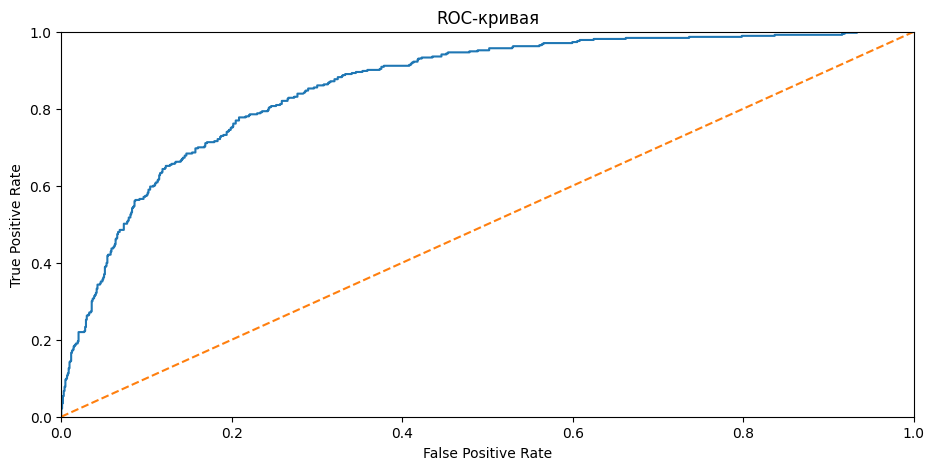

In [59]:
log_reg_predected_probas = log_reg_model.predict_proba(features_test)[:, 1]
plot_roc_curve(target_test, log_reg_predected_probas)

CatBoost показал лучшее значеие метрики ROC_AUC = 0.947

Выведем важность признаков

In [60]:
features_relevance = pd.DataFrame(CV_CBC.best_estimator_.feature_importances_, index = features_test.columns, columns=['relevance'])
features_relevance = features_relevance.round(2).sort_values(by=['relevance'], ascending=False)
features_relevance

,relevance
TotalDays,31.69
MonthlyCharges,4.78
Gender_Female,3.75
Gender_Male,3.73
PaperlessBilling_No,3.14
OnlineBackup_No,3.09
PaymentMethod_Electronic check,2.98
Partner_No,2.95
OnlineBackup_Yes,2.88
PaymentMethod_Mailed check,2.88


Выведем матрицу ошибок на тестовой выборки

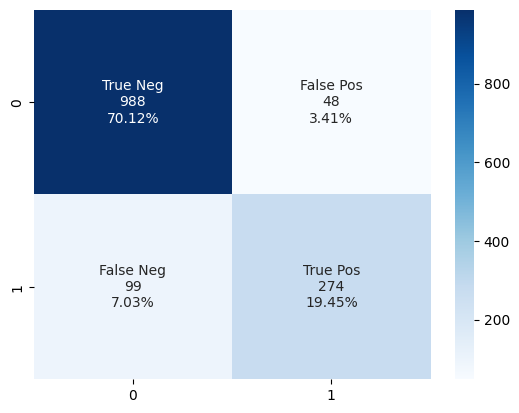

In [82]:
test_pool = Pool(data=features_test, label=target_test)
matrix_conf = get_confusion_matrix(catboost_model, test_pool)

group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                matrix_conf.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     matrix_conf.flatten()/np.sum(matrix_conf)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(matrix_conf, annot=labels, fmt='', cmap='Blues')
plt.show()


По матрице ошибок видно, что модель одинаково хорошо предсказывает оба класса

### Выводы:
- Лучшая модель CatBoost
- Основным показателем является кол-во дней пользования услугами, также влияют тип оплаты и гендер

## **Резюме по выполненной работе**

- В данной работе проведена работа по предсказанию отказа ли клиент от услуг 
- Сначала данные были прочитаны и по ним были сделаны предварительные выводы
- Была произведена первичная обработка данных - переименованы столбцы, изменены типы данных
- Затем был проведен исследовательский анализ данных - проанализированы количественные и категоральные признаки, проведена попытка найти связь между ними и целевым признаком
- После этого была проведена подготовка данных к обучению моделей: удалены ненужные столбцы, применена техника OHE, датафрейм был разделен на обучающую и тестовую выборки, проведено масштабирование количественных признаков и проведен oversample
- После были обучены 3 модели: CatBoostClassifier, LogisticRegression, и RandomForestClassifier.
Лучший результат показала модель CatBoostClassifier со значением метрики ROC-AUC = 0.947, что выше
- Самым важным фактором оказалсась длительность пользования услугами